## Import Data

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import joblib
import optuna

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles
import xgboost as xgb
import csv
import sys
import torch as th
import torch.nn.functional as fn

/home/affiah/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-04 22:29:01.726794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 22:29:02.130758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 22:29:02.130818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 22:29:02.132561: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 

In [2]:
# df = pd.read_csv('data/smiles_embeddings_all.csv')
# df.head()

,Unnamed: 0,DrugBankID,SMILES,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,...,embedding_390,embedding_391,embedding_392,embedding_393,embedding_394,embedding_395,embedding_396,embedding_397,embedding_398,embedding_399
0,0,Compound::DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,-0.659347,-0.344230,-0.578348,-0.670077,0.073021,-0.844866,-0.529099,...,0.722160,-0.361777,-0.069529,0.719951,0.765324,-0.828312,-0.750704,-0.360401,-0.359896,-0.820253
1,1,Compound::DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,-0.606968,-0.781302,-0.730112,-0.868258,0.363371,-0.388290,0.217138,...,-0.355017,0.657896,0.039386,-0.395858,-0.218164,-0.540272,-0.603087,-0.853275,0.545669,-0.836144
2,2,Compound::DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,-0.470256,-0.885203,-0.623956,-0.507102,0.395201,-0.298908,-0.156826,...,-0.430036,0.563329,0.419391,-0.074537,0.266462,-0.631508,-0.637233,-0.816603,0.416263,-0.720862
3,3,Compound::DB00027,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,-0.761337,-0.709398,0.665223,-0.388625,0.218644,-0.416196,0.594226,...,-0.721291,0.630432,0.817134,0.515158,-0.247925,-0.523338,-0.827212,-0.751571,-0.640211,-0.756264
4,4,Compound::DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,-0.764784,-0.956786,-0.445434,-0.611626,0.335249,0.044306,-0.635370,...,-0.204678,-0.404126,-0.018485,-0.401169,0.025806,-0.664728,-0.856459,-0.417736,-0.386456,-0.626406


In [3]:
# df.shape

(8807, 403)

In [4]:
# # Drop the untitled column
# df.drop(['Unnamed: 0'], inplace=True, axis=1)
# df.head()

,DrugBankID,SMILES,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_390,embedding_391,embedding_392,embedding_393,embedding_394,embedding_395,embedding_396,embedding_397,embedding_398,embedding_399
0,Compound::DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,-0.659347,-0.344230,-0.578348,-0.670077,0.073021,-0.844866,-0.529099,-0.797582,...,0.722160,-0.361777,-0.069529,0.719951,0.765324,-0.828312,-0.750704,-0.360401,-0.359896,-0.820253
1,Compound::DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,-0.606968,-0.781302,-0.730112,-0.868258,0.363371,-0.388290,0.217138,-0.640213,...,-0.355017,0.657896,0.039386,-0.395858,-0.218164,-0.540272,-0.603087,-0.853275,0.545669,-0.836144
2,Compound::DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,-0.470256,-0.885203,-0.623956,-0.507102,0.395201,-0.298908,-0.156826,-0.697836,...,-0.430036,0.563329,0.419391,-0.074537,0.266462,-0.631508,-0.637233,-0.816603,0.416263,-0.720862
3,Compound::DB00027,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,-0.761337,-0.709398,0.665223,-0.388625,0.218644,-0.416196,0.594226,-0.497919,...,-0.721291,0.630432,0.817134,0.515158,-0.247925,-0.523338,-0.827212,-0.751571,-0.640211,-0.756264
4,Compound::DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,-0.764784,-0.956786,-0.445434,-0.611626,0.335249,0.044306,-0.635370,-0.706563,...,-0.204678,-0.404126,-0.018485,-0.401169,0.025806,-0.664728,-0.856459,-0.417736,-0.386456,-0.626406


## Split data into train and test set 
Store the data as a CSV file.

In [6]:
# Split the DataFrame into train and test sets (80% train, 20% test)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Save the train and test sets to CSV files
# train_df.to_csv('data/train.csv', index=False)
# test_df.to_csv('data/test.csv', index=False)

## Morgan Fingerprint Model

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
RADIUS = 2
N_BITS = 2048

# Function to calculate Morgan fingerprints
def calculate_morgan_fingerprint(smiles, radius=RADIUS, n_bits=N_BITS):
    '''Function to convert SMILES to fingerprint using the Morgan Fingerprint.

    Parameters
    -----------
    smiles (str): SMILES of the compound.
    radius (int): controls the radius of the fingerprint.
    n_bits (int): controls the length of the fingerprint bit vector.

    Returns
    -------
    arr (NumPy Array): fingerprint of SMILES
    '''
    # Convert the input SMILES string into an RDKit molecule object.
    mol = MolFromSmiles(smiles)
    # If the molecule conversion is successful, then generate the fingerprint
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((1,))
        AllChem.DataStructs.ConvertToNumpyArray(fingerprint, arr)
        return arr
    else:
        return None


# Function to preprocess data and create embeddings
def preprocess_data(df):
    # Get the target embeddings
    embeddings = df.iloc[:, 2:].values
    # create fingerprint column
    df['morgan_fingerprint'] = df['SMILES'].apply(calculate_morgan_fingerprint)
    df = df.dropna()
    # Extract the fingerprints as a NumPy array
    morgan_fingerprints = np.array(df['morgan_fingerprint'].tolist())
    return morgan_fingerprints, embeddings

In [4]:
# The morgan_fingerprints is X, our features
# The embeddings is y, our target variable
X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

print("The length of X_train is:", len(X_train))
print("The length of X_test is:", len(X_test))

[22:29:14] Unusual charge on atom 0 number of radical electrons set to zero


The length of X_train is: 7045
The length of X_test is: 1762


In [5]:
print(X_train.shape)
print(X_train)

(7045, 2048)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [6]:
print(y_train.shape)

(7045, 400)


## Train Model with XGBoost

In [7]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "n_jobs": -1,  # Set to -1 to use all available CPU cores
        "tree_method": "hist",  # Enable GPU acceleration
        "device": "cuda",  # Specify GPU as the device
    }
    # Create an XGBoost regressor with the suggested hyperparameters
    xgb_regressor = xgb.XGBRegressor(**params)
    xgb_regressor.fit(X_train, y_train, verbose=True)
    # Make predictions on the validation set
    y_pred = xgb_regressor.predict(X_test)
    # Calculate mean squared error for each target variable
    mse_per_target = np.mean((y_test - y_pred)**2, axis=0)
    print("mse per target", mse_per_target)
    # Average the mean squared errors across all target variables
    mse = np.mean(mse_per_target)
    return mse

In [8]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

# Print the best hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'Params: {trial.params}')
print(f'Mean Squared Error: {trial.value}')

[I 2024-01-04 22:30:52,077] A new study created in memory with name: no-name-c64b33e4-78ad-4c5e-8e37-6a4c00f78039
[W 2024-01-04 22:47:05,860] Trial 0 failed with parameters: {'n_estimators': 323, 'learning_rate': 0.0016356703408991033, 'max_depth': 6, 'subsample': 0.4142053882282948, 'colsample_bytree': 0.19200522964605654, 'min_child_weight': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/affiah/anaconda3/envs/drkg/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_6046/2862721959.py", line 19, in objective
    xgb_regressor.fit(X_train, y_train, verbose=True)
  File "/home/affiah/anaconda3/envs/drkg/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/home/affiah/anaconda3/envs/drkg/lib/python3.10/site-packages/xgboost/sklearn.py", line 1090, in fit
    self._Booster = train(
  File "/home/af

KeyboardInterrupt: 

In [15]:
# Extract the best hyperparameters
best_params = study.best_trial.params
# Create an XGBoost regressor with the best hyperparameters
best_xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
# Train the final model using the full training set
best_xgb_regressor.fit(X_train, y_train)
# Make predictions on your test set or perform any further evaluation
y_test_pred = best_xgb_regressor.predict(X_test)

In [16]:
# Save the trained model to a file
model_filename = 'xgboost_mf_model.bin'
joblib.dump(best_xgb_regressor, model_filename)

['xgboost_mf_model.bin']

In [17]:
# Load the saved model
model = joblib.load('xgboost_mf_model.bin')

# Make predictions on the test set
mf_embeddings = model.predict(X_test)
train_mf_embeddings = model.predict(X_train)
print(mf_embeddings)
print(train_mf_embeddings)

[[-0.1475523   0.28887412 -0.21722725 ... -0.17740187  0.17419808
  -0.09228424]
 [-0.09627467  0.29536265 -0.19031638 ...  0.19803649  0.10175716
   0.00223647]
 [-0.21275802  0.35666412 -0.13411956 ...  0.012276    0.275304
  -0.10144049]
 ...
 [ 0.01799346  0.22322619 -0.28476098 ... -0.01041451  0.49920142
  -0.3580165 ]
 [ 0.01346731  0.16412038 -0.13551407 ... -0.04858524  0.18588357
  -0.11764365]
 [ 0.04554345  0.2899301  -0.19250783 ...  0.04988091  0.12740843
  -0.05790442]]
[[ 0.08322062  0.34461492 -0.07859088 ...  0.10845882  0.1440753
  -0.07921766]
 [-0.08786265  0.24800949 -0.2527534  ...  0.09698407  0.2594028
  -0.04009469]
 [-0.26451927  0.41204485  0.13812092 ... -0.08820601  0.5518651
   0.24682476]
 ...
 [-0.03615626  0.262883   -0.1695464  ... -0.06459307  0.28243217
  -0.17927052]
 [-0.00731703  0.25970662 -0.1828585  ... -0.03676578  0.50548625
  -0.48915145]
 [-0.12434753  0.1686933  -0.11293892 ... -0.21867155  0.2975768
  -0.25298122]]


In [18]:
# Calculate R-squared score for each output
r2_scores_test = [r2_score(y_test[:, i], mf_embeddings[:, i]) for i in range(y_test.shape[1])]
r2_scores_train = [r2_score(y_train[:, i], train_mf_embeddings[:, i]) for i in range(y_train.shape[1])]

# Print the average R-squared score
average_r2_test = np.mean(r2_scores_test)
average_r2_train = np.mean(r2_scores_train)

print(f'Average Train R-squared Score: {average_r2_train:.4f}')
print(f'Average Test R-squared Score: {average_r2_test:.4f}')

Average Train R-squared Score: 0.1566
Average Test R-squared Score: 0.0797


## Evaluate Embeddings

### Column-wise evaluation
Compare the embeddings based on the index (original and predicted) of all the drugs


In [19]:
def col_comparison(embedding_index, original_embeddings=y_test, predicted_embeddings=mf_embeddings):
    '''Function to compare the original embeddings with the predicted embeddings.
    It uses a regression plot and Pearson correlation for comparison.
        
    Parameter
    ----------
    embedding_index (int): number specifying the embedding you want to compare. It ranges from 0-399.
    original_embeddings (np.array): The original embeddings from the knowledge graph.
    predicted_embeddingns (np.array): The embeddings predicted by the model
    
    Returns
    -------
    pearson_corr (np.array): person correlation score.
    '''
    # Extract embedding_index for both arrays
    embedding_index_y_test = original_embeddings[:, embedding_index]
    embedding_index_mf = predicted_embeddings[:, embedding_index]

    # Create a DataFrame for Seaborn plotting
    emb_df = pd.DataFrame({'Embedding_index_y_test': embedding_index_y_test,
                       'Embedding_index_mf': embedding_index_mf})

    # Plot the regression plot with Pearson correlation
    plt.figure(figsize=(6,4))
    sns.regplot(x='Embedding_index_y_test', y='Embedding_index_mf', data=emb_df, scatter_kws={'s': 10})
    plt.title(f'Regression Plot of Embedding_{embedding_index}')
    plt.xlabel(f'Original Embedding {embedding_index}')
    plt.ylabel(f'Predicted Embedding {embedding_index}')
    plt.show()

    # Calculate the Pearson correlation
    pearson_corr = np.corrcoef(embedding_index_y_test, embedding_index_mf)[0, 1]
    print(f'Pearson Correlation: {pearson_corr:.4f}')

#### Test Set

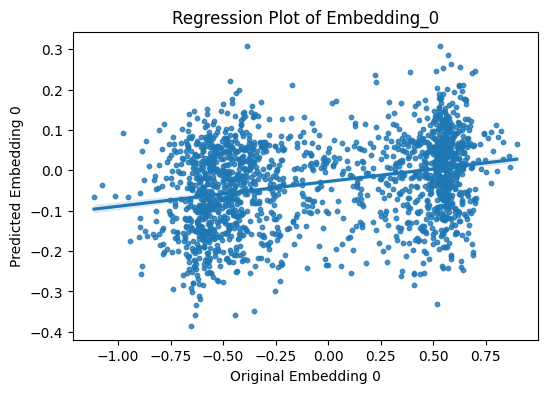

Pearson Correlation: 0.2931


In [20]:
col_comparison(0)

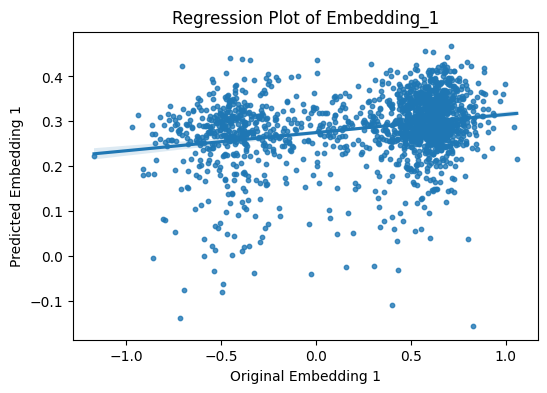

Pearson Correlation: 0.2625


In [21]:
col_comparison(1)

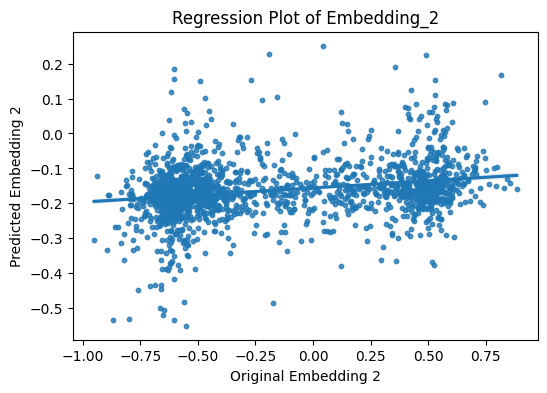

Pearson Correlation: 0.2413


In [22]:
col_comparison(2)

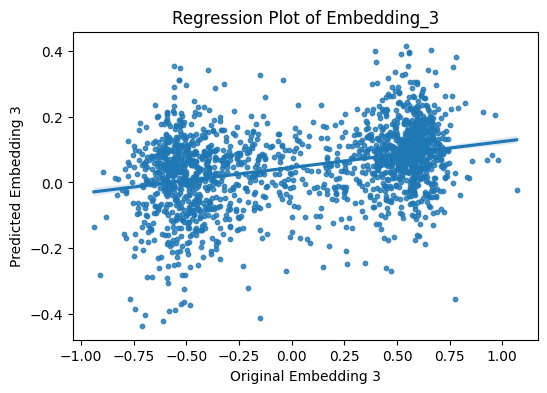

Pearson Correlation: 0.3444


In [23]:
col_comparison(3)

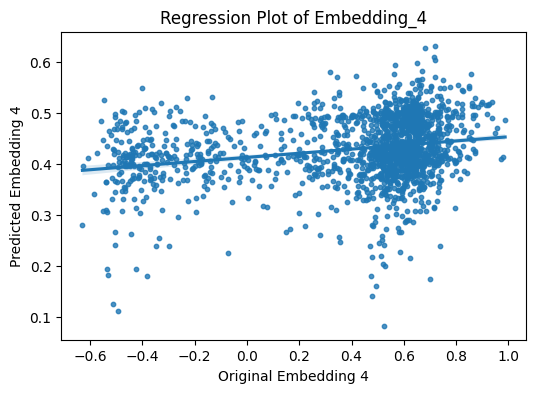

Pearson Correlation: 0.2339


In [24]:
col_comparison(4)

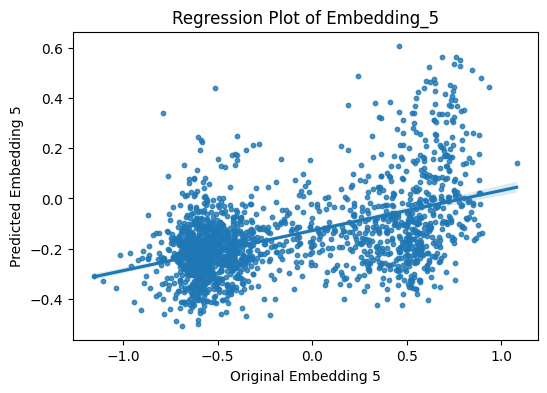

Pearson Correlation: 0.4901


In [25]:
col_comparison(5)

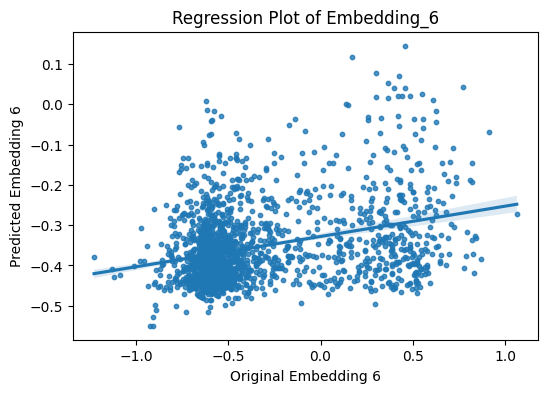

Pearson Correlation: 0.3199


In [26]:
col_comparison(6)

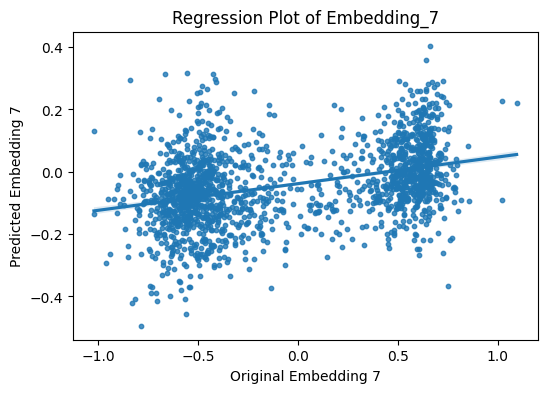

Pearson Correlation: 0.3736


In [27]:
col_comparison(7)

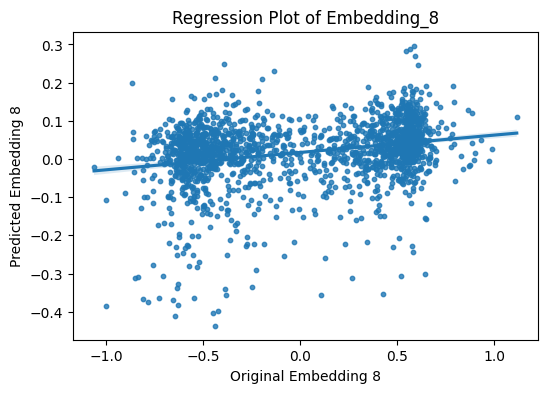

Pearson Correlation: 0.2627


In [28]:
col_comparison(8)

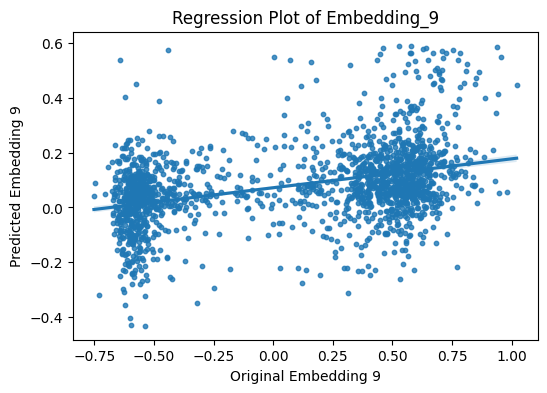

Pearson Correlation: 0.3805


In [29]:
col_comparison(9)

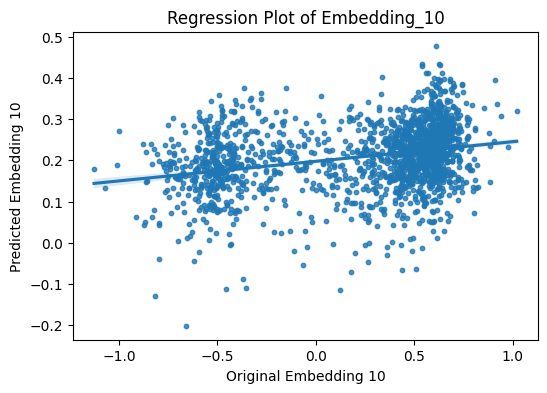

Pearson Correlation: 0.2836


In [30]:
col_comparison(10)

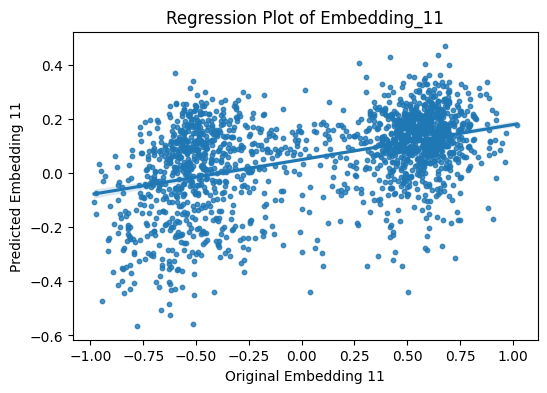

Pearson Correlation: 0.4431


In [31]:
col_comparison(11)

#### Train Set

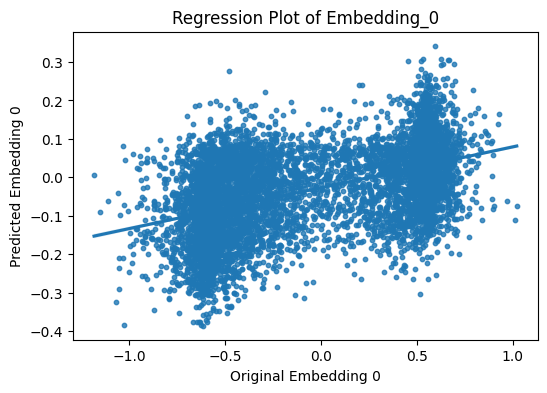

Pearson Correlation: 0.4896


In [32]:
col_comparison(0, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

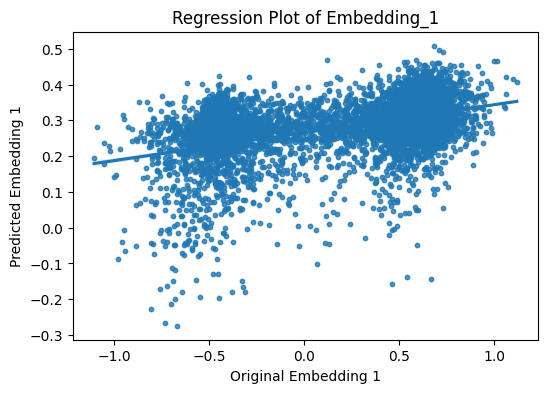

Pearson Correlation: 0.4669


In [33]:
col_comparison(1, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

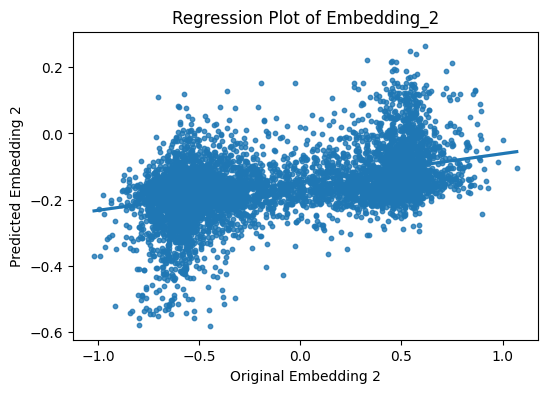

Pearson Correlation: 0.4750


In [34]:
col_comparison(2, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

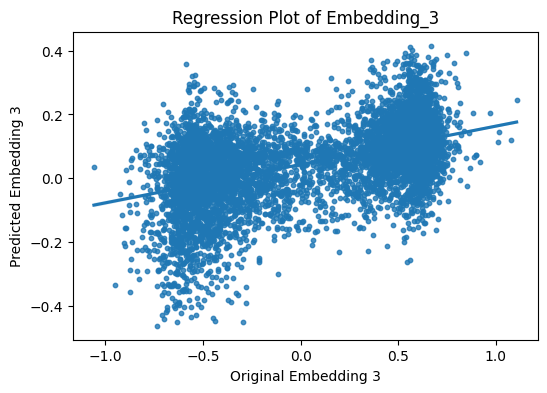

Pearson Correlation: 0.5002


In [35]:
col_comparison(3, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

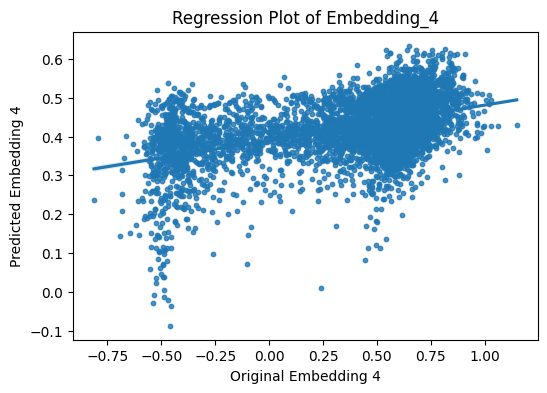

Pearson Correlation: 0.4674


In [36]:
col_comparison(4, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

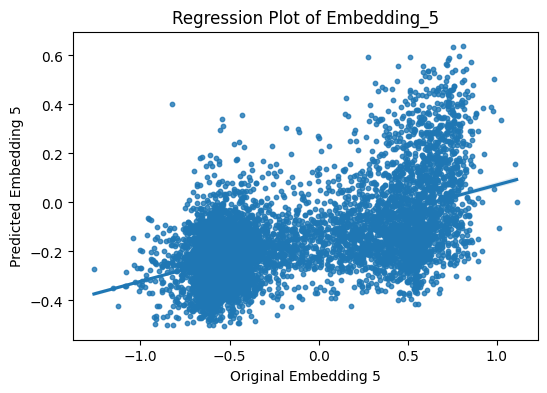

Pearson Correlation: 0.5836


In [37]:
col_comparison(5, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

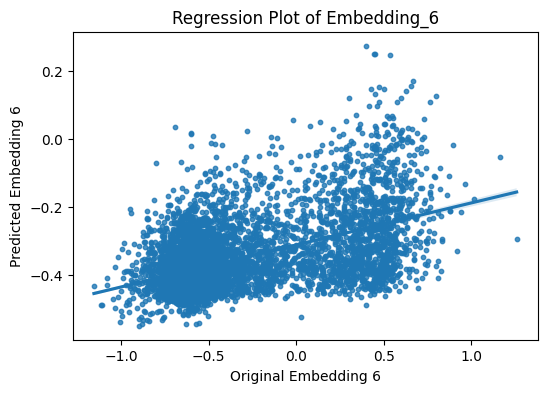

Pearson Correlation: 0.5148


In [38]:
col_comparison(6, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

### Row-wise Comparison of Embeddings
Compare the 400 embeddings (original and predicted) of a particular drug

In [39]:
def row_comparison(drug_index, original_embeddings=y_test, predicted_embeddings=mf_embeddings):
    '''Function to compare the 400 original embeddings with the predicted embeddings for a drug
    It uses a regression plot and Pearson correlation for comparison.
        
    Parameter
    ----------
    drug_index (int): number specifying the drug embedding you want to compare. It ranges from 0-1761.
    original_embeddings (np.array): The original embeddings from the knowledge graph.
    predicted_embeddingns (np.array): The embeddings predicted by the model
    
    Returns
    -------
    pearson_corr (np.array): person correlation score.
    '''
    # Extract embeddings for the specified drug
    embeddings_y_test = original_embeddings[drug_index]
    embeddings_mf = predicted_embeddings[drug_index]

    # Create a DataFrame for Seaborn plotting
    df = pd.DataFrame({'Embeddings_y_test': embeddings_y_test,
                       'Embeddings_mf': embeddings_mf})

    # Plot the regression plot
    plt.figure(figsize=(6,4))
    sns.regplot(x='Embeddings_y_test', y='Embeddings_mf', data=df, scatter_kws={'s': 10})
    plt.title(f'Regression Plot of Embeddings for Drug {drug_index}')
    plt.xlabel(f'Original Embeddings for Drug {drug_index}')
    plt.ylabel(f'Predicted Embeddings for Drug {drug_index}')
    plt.show()

     # Calculate the Pearson correlation
    pearson_corr = np.corrcoef(embeddings_y_test, embeddings_mf)[0, 1]
    print(f'Pearson Correlation: {pearson_corr:.4f}')

#### Test Set

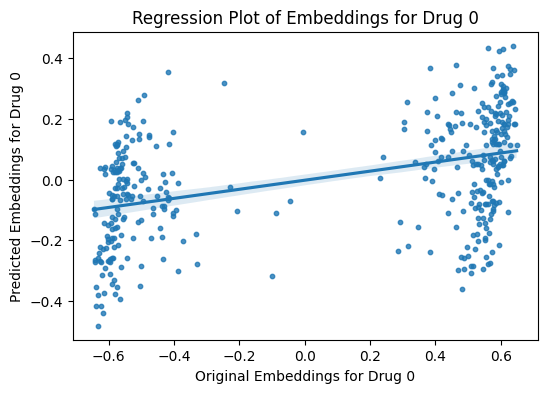

Pearson Correlation: 0.4245


In [40]:
row_comparison(0)

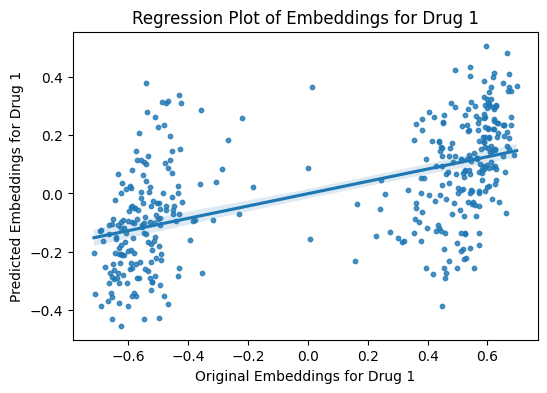

Pearson Correlation: 0.5580


In [41]:
row_comparison(1)

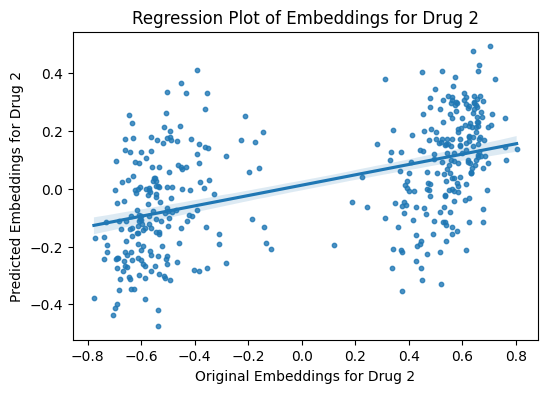

Pearson Correlation: 0.5057


In [42]:
row_comparison(2)

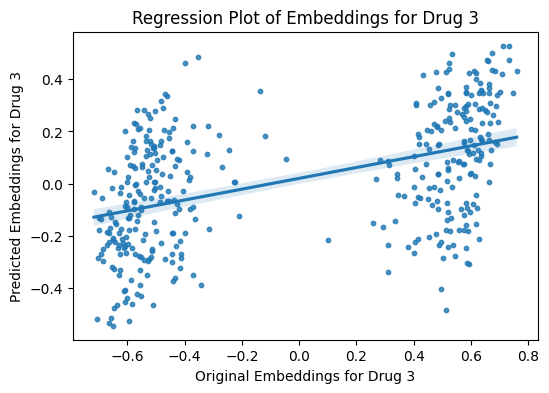

Pearson Correlation: 0.4730


In [43]:
row_comparison(3)

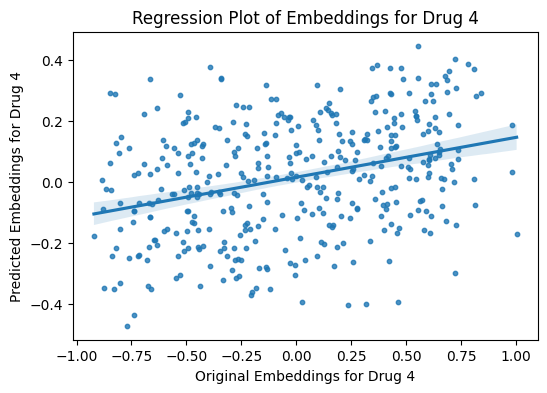

Pearson Correlation: 0.3272


In [44]:
row_comparison(4)

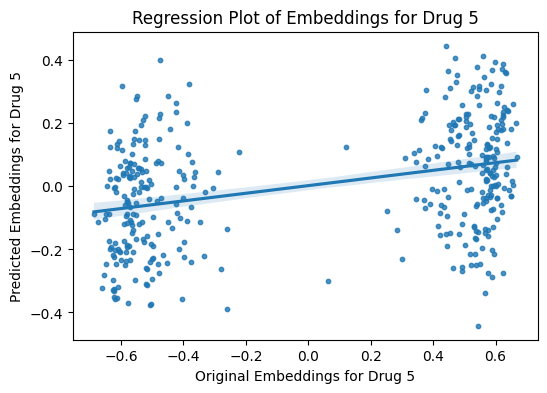

Pearson Correlation: 0.3551


In [45]:
row_comparison(5)

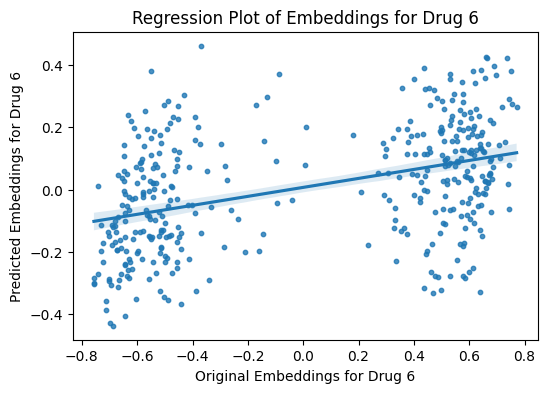

Pearson Correlation: 0.4200


In [46]:
row_comparison(6)

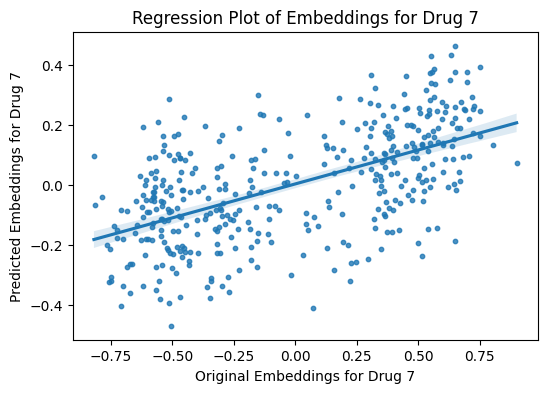

Pearson Correlation: 0.5765


In [47]:
row_comparison(7)

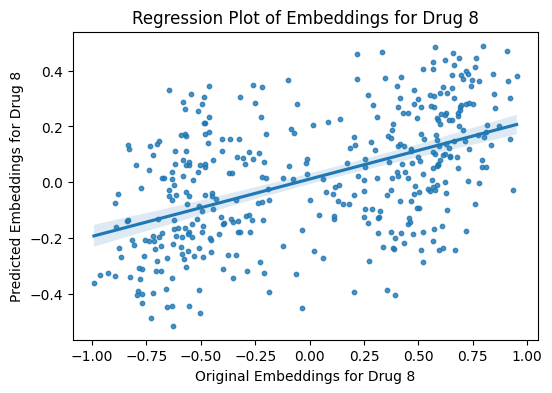

Pearson Correlation: 0.5045


In [48]:
row_comparison(8)

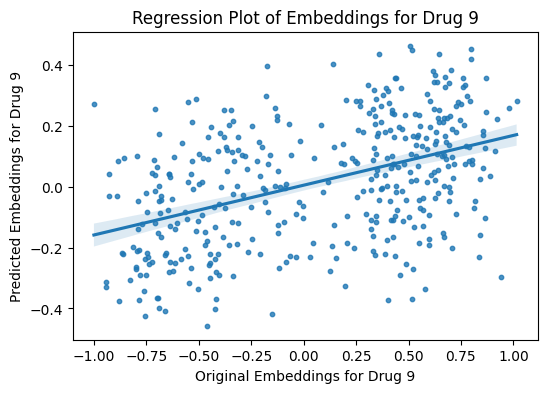

Pearson Correlation: 0.4444


In [49]:
row_comparison(9)

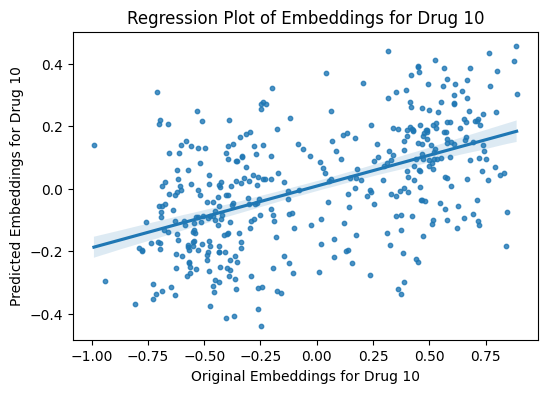

Pearson Correlation: 0.5122


In [50]:
row_comparison(10)

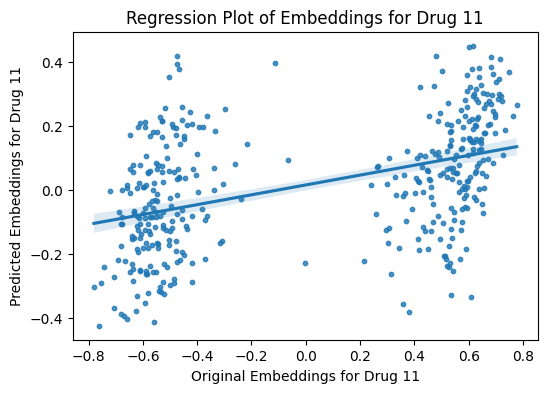

Pearson Correlation: 0.4437


In [51]:
row_comparison(11)

#### Train Set

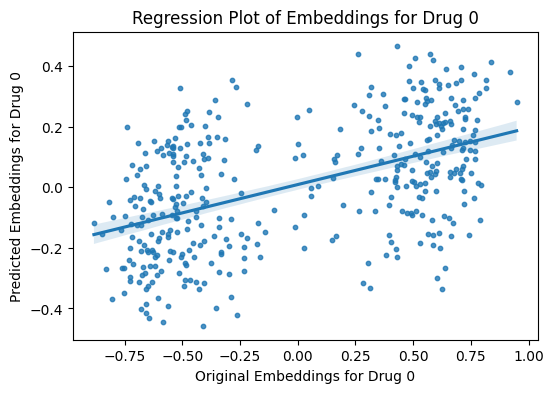

Pearson Correlation: 0.5063


In [52]:
row_comparison(0, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

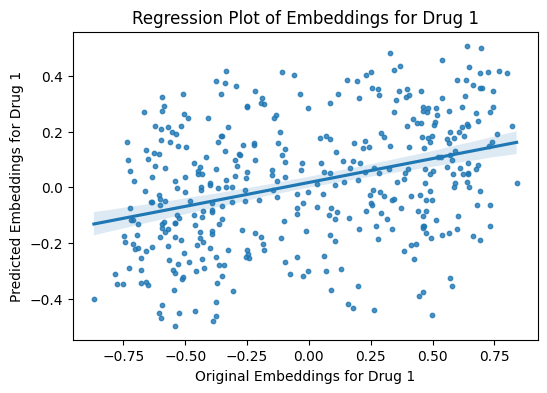

Pearson Correlation: 0.3553


In [53]:
row_comparison(1, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

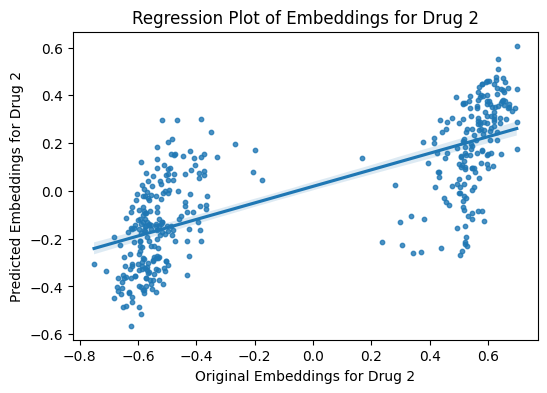

Pearson Correlation: 0.7342


In [54]:
row_comparison(2, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

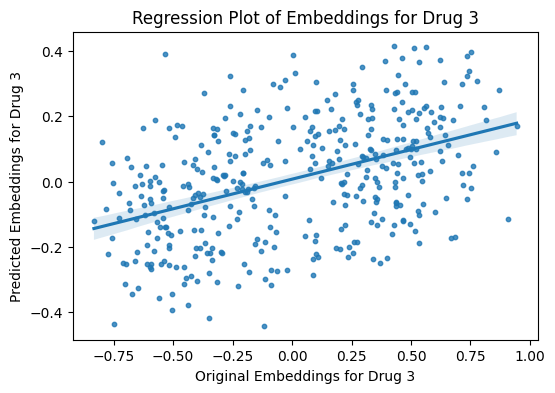

Pearson Correlation: 0.4421


In [55]:
row_comparison(3, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

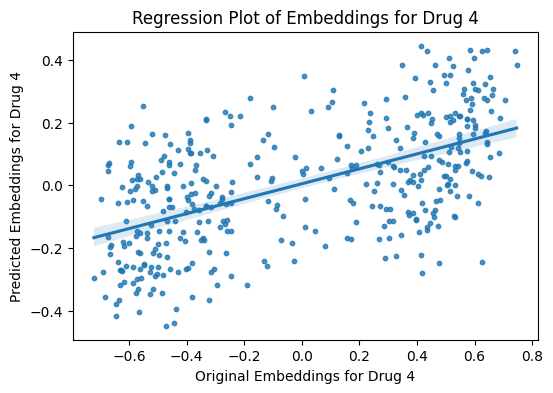

Pearson Correlation: 0.5649


In [56]:
row_comparison(4, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

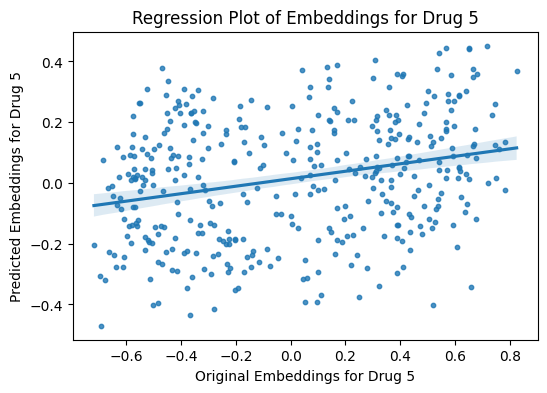

Pearson Correlation: 0.2641


In [57]:
row_comparison(5, 
               original_embeddings=y_train, 
               predicted_embeddings=train_mf_embeddings)

## Predict the Edge Score

In [58]:
COV_disease_list = [
'Disease::SARS-CoV2 E',
'Disease::SARS-CoV2 M',
'Disease::SARS-CoV2 N',
'Disease::SARS-CoV2 Spike',
'Disease::SARS-CoV2 nsp1',
'Disease::SARS-CoV2 nsp10',
'Disease::SARS-CoV2 nsp11',
'Disease::SARS-CoV2 nsp12',
'Disease::SARS-CoV2 nsp13',
'Disease::SARS-CoV2 nsp14',
'Disease::SARS-CoV2 nsp15',
'Disease::SARS-CoV2 nsp2',
'Disease::SARS-CoV2 nsp4',
'Disease::SARS-CoV2 nsp5',
'Disease::SARS-CoV2 nsp5_C145A',
'Disease::SARS-CoV2 nsp6',
'Disease::SARS-CoV2 nsp7',
'Disease::SARS-CoV2 nsp8',
'Disease::SARS-CoV2 nsp9',
'Disease::SARS-CoV2 orf10',
'Disease::SARS-CoV2 orf3a',
'Disease::SARS-CoV2 orf3b',
'Disease::SARS-CoV2 orf6',
'Disease::SARS-CoV2 orf7a',
'Disease::SARS-CoV2 orf8',
'Disease::SARS-CoV2 orf9b',
'Disease::SARS-CoV2 orf9c',
'Disease::MESH:D045169',
'Disease::MESH:D045473',
'Disease::MESH:D001351',
'Disease::MESH:D065207',
'Disease::MESH:D028941',
'Disease::MESH:D058957',
'Disease::MESH:D006517'
]

treatment = ['Hetionet::CtD::Compound:Disease','GNBR::T::Compound:Disease']


gamma = 12.0

def transE_l2(head, rel, tail):
    score = head + rel - tail
    return gamma - th.norm(score, p=2, dim=-1)


def edge_score(embeddings):
    '''Function to calculate the edge scores.

    Argument
    ---------
    embeddings (array). Array of size 400 containing 
            the embeddings of the SMILES molecule.

    Returns
    --------
    scores (tensor). Tensor showing the edge score for 
            each disease based on the drug_embeddings, relation_embeddings,
            and COVID_disease embeddings.
    '''
    
    # Load entity and relation mapping files
    entity_idmap_file = 'data/entities.tsv'
    relation_idmap_file = 'data/relations.tsv'

    # Get drugname/disease name to entity ID mappings
    entity_map = {}
    entity_id_map = {}
    relation_map = {}
    
    with open(entity_idmap_file, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name', 'id'])
        for row_val in reader:
            entity_map[row_val['name']] = int(row_val['id'])
            entity_id_map[int(row_val['id'])] = row_val['name']

    with open(relation_idmap_file, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name', 'id'])
        for row_val in reader:
            relation_map[row_val['name']] = int(row_val['id'])

    # Handle the ID mapping
    # drug_ids = [entity_map[drug] for drug in drug_list]
    disease_ids = [entity_map[disease] for disease in COV_disease_list]
    treatment_rid = [relation_map[treat] for treat in treatment]

    # Load embeddings
    entity_emb = np.load('data/DRKG_TransE_l2_entity.npy')
    rel_emb = np.load('data/DRKG_TransE_l2_relation.npy')

    # drug_ids = th.tensor(drug_ids).long()
    disease_ids = th.tensor(disease_ids).long()
    treatment_rid = th.tensor(treatment_rid)

    # Use our model's embeddings here
    drug_emb = th.tensor(embeddings)
    # drug_emb = th.tensor(entity_emb[drug_ids]) # get embeddings from knowledge graph
    
    treatment_embs = [th.tensor(rel_emb[rid]) for rid in treatment_rid]

    scores_per_disease = []
    for rid in range(len(treatment_embs)):
        treatment_emb=treatment_embs[rid]
        for disease_id in disease_ids:
            disease_emb = entity_emb[disease_id]
            score = fn.logsigmoid(transE_l2(drug_emb, treatment_emb, disease_emb))
            scores_per_disease.append(score)
            
    # Convert scores_per_disease to a list of tensors
    scores_tensors = [th.tensor(scores, dtype=th.float32) for scores in scores_per_disease]
    # Get the first combo edge score
    return scores_tensors[0]

    # # Ensure the list of tensors is not empty before calculating the max
    # if scores_tensors:
    #     # Stack the list of tensors along a new dimension (axis 0)
    #     scores_tensor = th.stack(scores_tensors, dim=0)
    #     # Calculate the maximum score for each drug along the existing dimension (axis 0)
    #     max_scores, _ = th.max(scores_tensor, dim=0)
    #     # Print the shape and content of the max_scores tensor
    #     print("Shape of max_scores:", max_scores.shape)
    #     # print("Maximum scores for each drug:", max_scores.tolist())  # Use .tolist() to get a Python list
    #     return max_scores
    # else:
    #     print("The list of tensors is empty.")
    #     return None

In [59]:
# y_test has the original embeddings
# Predict the original_edge_score
original_edge_score = edge_score(y_test)
# Predict the Morgan Fingerprint edge score
mf_edge_score = edge_score(mf_embeddings)

# Do the same for the training set
original_train_edge_score = edge_score(y_train)
mf_train_edge_score = edge_score(train_mf_embeddings)

/tmp/ipykernel_16126/31520054.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores_tensors = [th.tensor(scores, dtype=th.float32) for scores in scores_per_disease]


In [60]:
print(mf_edge_score)
print(original_edge_score)

tensor([-3.3040, -3.2228, -3.3156,  ..., -3.0769, -3.3007, -3.4495])
tensor([-7.0180, -6.4491, -6.4137,  ..., -6.0347, -5.3829, -6.3878])


In [61]:
print(original_train_edge_score)
print(mf_train_edge_score)

tensor([-6.5037, -4.0552, -6.3711,  ..., -6.4876, -3.8636, -6.0133])
tensor([-3.3865, -3.3988, -3.7280,  ..., -3.1221, -3.1780, -3.3096])


## Plot result

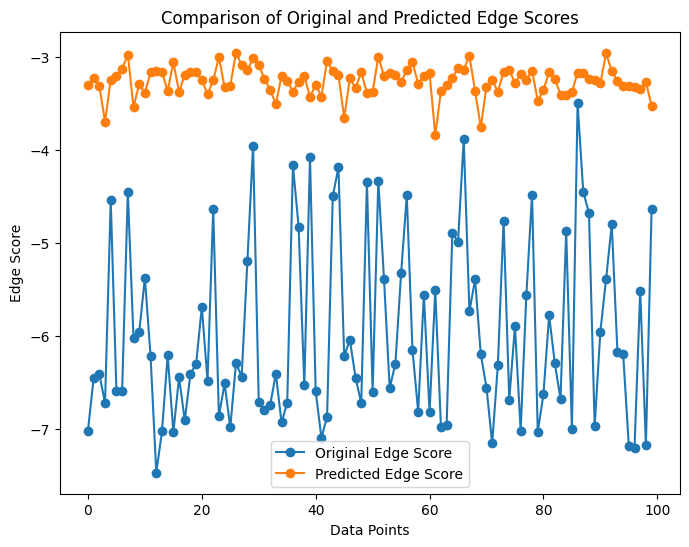

R-squared Score: -9.0939
Mean Squared Error: 8.3849


In [62]:
def plot_result(orignial_score=original_edge_score, predicted_score=mf_edge_score):
    # Calculate R-squared score
    r2 = r2_score(orignial_score, predicted_score)
    # Calculate Mean Squared Error
    mse = mean_squared_error(orignial_score, predicted_score)

    # Plot the line graph
    plt.figure(figsize=(8, 6))
    plt.plot(orignial_score[:100], label='Original Edge Score', marker='o')
    plt.plot(predicted_score[:100], label='Predicted Edge Score', marker='o')
    plt.title('Comparison of Original and Predicted Edge Scores')
    plt.xlabel('Data Points')
    plt.ylabel('Edge Score')
    plt.legend()
    plt.show()

    # Print R-squared and MSE
    print(f'R-squared Score: {r2:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')

plot_result()

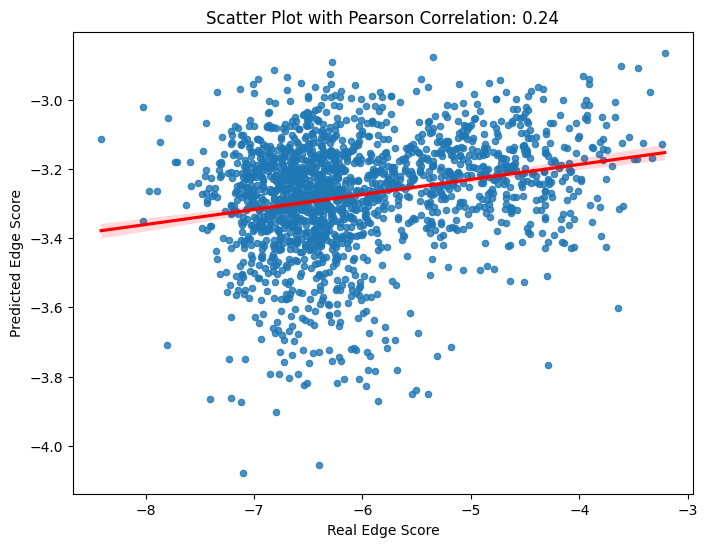

In [63]:
def scatter_plot(original_score=original_edge_score, predicted_score=mf_edge_score):
    # Create a DataFrame for seaborn
    data = {'Original Score':original_score,
            'Predicted Score':predicted_score}
    df = pd.DataFrame(data)
    # Create a scatter plot with regression line
    plt.figure(figsize=(8,6))
    sns.regplot(x='Original Score', y='Predicted Score', data=df, scatter_kws={'s': 20}, line_kws={'color': 'red'})

    # Calculate and display Pearson correlation coefficient
    pearson_corr = df.corr().loc['Original Score', 'Predicted Score']
    plt.title(f'Scatter Plot with Pearson Correlation: {pearson_corr:.2f}')
    plt.xlabel('Real Edge Score')
    plt.ylabel('Predicted Edge Score')
    plt.show()


scatter_plot()

#### Train Result Comparison

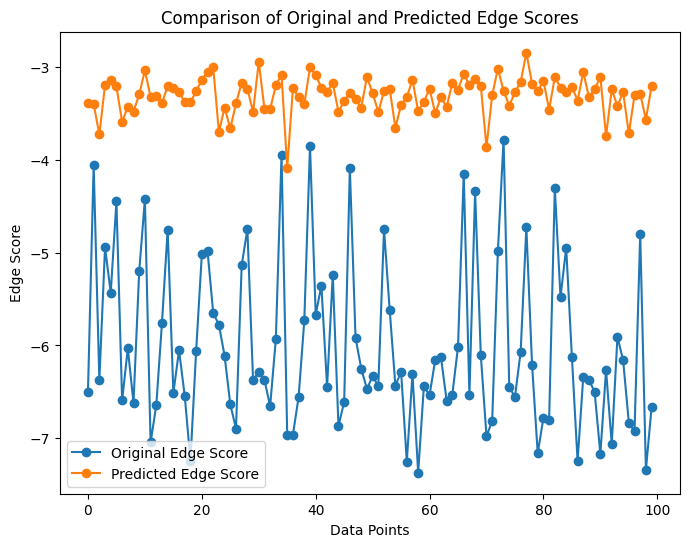

R-squared Score: -8.9768
Mean Squared Error: 8.3410


In [64]:
# Train Data
plot_result(original_train_edge_score, mf_train_edge_score)

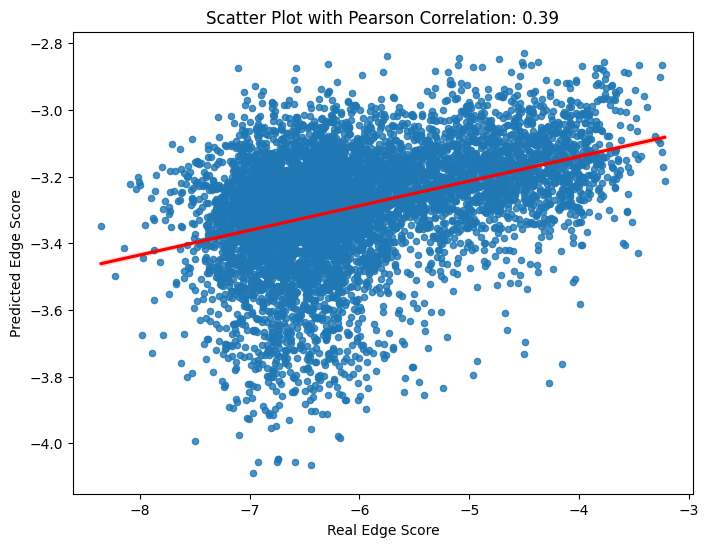

In [65]:
scatter_plot(original_train_edge_score, mf_train_edge_score)